#### The dataset used here is day_9_test_new.txt , and should be renamed as Test_day_9.txt in order to run the code

In [11]:
# Import libraries
'''Main'''
import numpy as np
import pandas as pd
import os, time
import pickle, gzip

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [12]:
# dataset_train = pd.read_csv("Training_day_9.txt", sep = ",", na_values = ['?','.'])
dataset_test = pd.read_csv("Test_day_9.txt", sep = ",", na_values = ['?','.'])

In [15]:
dataset_test.head()

,source_user@domain,destination_user@domain,source_computer,destination_computer,authentication_type,logon_type,authentication_orientation,success,Malignant/Benign
0,U1653@DOM1,U1653@DOM1,C17693,C395,NTLM,Network,LogOn,Success,1
1,U2164@DOM1,U2164@DOM1,C6438,C2382,Kerberos,Network,LogOn,Success,0
2,U7988@DOM1,U7988@DOM1,C2039,C457,Kerberos,Network,LogOn,Success,0
3,C1708$@DOM1,C1708$@DOM1,C1709,C528,Kerberos,Network,LogOn,Success,0
4,C11388$@DOM1,C11388$@DOM1,C11388,C529,Kerberos,Network,LogOn,Success,0


In [14]:
# dataset_train = pd.read_csv("Training_day_9.txt", sep = ",", na_values = ['?','.'])
dataset_test = pd.read_csv("Test_day_9.txt", sep = ",", na_values = ['?','.'])
dataset_test.rename(columns={'anomaly':'Malignant/Benign'}, inplace=True)
# dataset_train = dataset_train.drop('Unnamed: 0',1)
# dataset_test = dataset_test.drop('Unnamed: 0',1)
# dataset_train = dataset_train.drop('time',1)
dataset_test = dataset_test.drop('time',1)

### Preprocessing of data

In [22]:
dataset_test.iloc[:,0] = pd.factorize(dataset_test.iloc[:,1])[0]
dataset_test.iloc[:,1] = pd.factorize(dataset_test.iloc[:,1])[0]
dataset_test.iloc[:,2] = pd.factorize(dataset_test.iloc[:,2])[0]
dataset_test.iloc[:,3] = pd.factorize(dataset_test.iloc[:,3])[0]
dataset_test.iloc[:,4] = pd.factorize(dataset_test.iloc[:,4])[0]
dataset_test.iloc[:,5] = pd.factorize(dataset_test.iloc[:,5])[0]
dataset_test.iloc[:,6] = pd.factorize(dataset_test.iloc[:,6])[0]
dataset_test.iloc[:,7] = pd.factorize(dataset_test.iloc[:,7])[0]

### Normalizing and scaling

In [24]:
dataX_test = dataset_test.copy().drop(['Malignant/Benign'],axis=1)
dataY_test = dataset_test['Malignant/Benign'].copy()

featuresToScale = dataX_test.columns
sX = pp.StandardScaler(copy=True)
dataX_test.loc[:,featuresToScale] = sX.fit_transform(dataX_test[featuresToScale])

X_train, X_test, y_train, y_test = \
    train_test_split(dataX_test, dataY_test, test_size=0.33, \
                    random_state=2018, stratify=dataY_test)

In [25]:
X_train.head(2)

,source_user@domain,destination_user@domain,source_computer,destination_computer,authentication_type,logon_type,authentication_orientation,success
5022,0.697203,0.697203,0.840624,-0.355047,0.187723,-0.188647,0.0,-0.069477
9761,-0.657841,-0.657841,-0.604139,-0.243592,0.187723,-0.188647,0.0,-0.069477


In [26]:
y_train.head(2)

5022    0
9761    0
Name: Malignant/Benign, dtype: int64

In [27]:
X_test.head(2)

,source_user@domain,destination_user@domain,source_computer,destination_computer,authentication_type,logon_type,authentication_orientation,success
1674,-0.480975,-0.480975,-0.403034,-0.343315,0.187723,-0.188647,0.0,-0.069477
9531,-0.180470,-0.180470,-0.066583,-0.319851,0.187723,-0.188647,0.0,-0.069477


In [28]:
y_test.head(2)

1674    0
9531    0
Name: Malignant/Benign, dtype: int64

In [29]:
# Define evaluation functions

In [30]:
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF)-np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

In [31]:
def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'],preds['anomalyScore'])
    average_precision = \
        average_precision_score(preds['trueLabel'],preds['anomalyScore'])
    F1 = \
        2/((1/precision) + (1/recall))
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.step(recall, F1, color='r', alpha=0.7, where='post', label='F1 curve')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    plt.title('Precision-Recall curve: Average Precision = \
    {0:0.2f}'.format(average_precision))
    plt.legend(loc="upper right")

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], \
                                     preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: \
    Area under the curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    
    if returnPreds==True:
        return preds

In [32]:
def scatterPlot(xDF, yDF, algoName):
    tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index)
    tempDF = pd.concat((tempDF,yDF), axis=1, join="inner")
    tempDF.columns = ["First Vector", "Second Vector", "Label"]
    sns.lmplot(x="First Vector", y="Second Vector", hue="Label", \
               data=tempDF, fit_reg=False)
    ax = plt.gca()
    ax.set_title("Separation of Observations using "+algoName)

## PCA

Prediction run in 1.08s


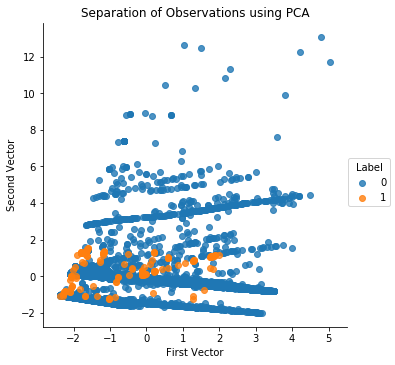

In [34]:
# 5 principal components
from sklearn.decomposition import PCA

n_components = 5
whiten = False
random_state = 2018

start_time = time.time()
pca = PCA(n_components=n_components, whiten=whiten, \
          random_state=random_state)

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=X_train.index)

X_train_PCA_inverse = pca.inverse_transform(X_train_PCA)
X_train_PCA_inverse = pd.DataFrame(data=X_train_PCA_inverse, \
                                   index=X_train.index)
stop_time = time.time()
print("Prediction run in %.2fs" % (stop_time - start_time))

scatterPlot(X_train_PCA, y_train, "PCA")

/home/trevor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


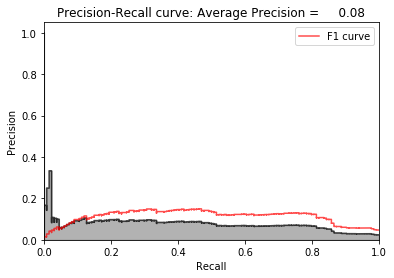

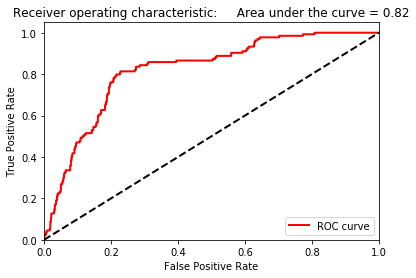

In [35]:
anomalyScoresPCA = anomalyScores(X_train, X_train_PCA_inverse)
preds = plotResults(y_train, anomalyScoresPCA, True)

In [36]:
preds.sort_values(by="anomalyScore",ascending=False,inplace=True)
cutoff = 200
predsTop = preds[:cutoff]
print("Precision: ",np.round(predsTop. \
            anomalyScore[predsTop.trueLabel==1].count()/cutoff,2))
print("Recall: ",np.round(predsTop. \
            anomalyScore[predsTop.trueLabel==1].count()/y_train.sum(),2))
print("Anomalies Caught out of 200 Cases:", predsTop.trueLabel.sum())

Precision:  0.08
Recall:  0.13
Anomalies Caught out of 200 Cases: 17


In [37]:
precision = np.round(predsTop. \
                     anomalyScore[predsTop.trueLabel==1].count()/cutoff,2)
recall = np.round(predsTop. \
            anomalyScore[predsTop.trueLabel==1].count()/y_train.sum(),2)
F1 = 2/((1/precision) + (1/recall))
print ("F1: ", np.round(F1, 2))

F1:  0.1


Prediction run in 0.01s


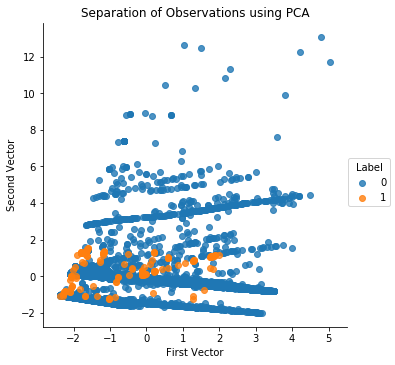

In [38]:
# 3 principal components
from sklearn.decomposition import PCA

n_components = 3
whiten = False
random_state = 2018

pca = PCA(n_components=n_components, whiten=whiten, \
          random_state=random_state)

start_time = time.time()
X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=X_train.index)

X_train_PCA_inverse = pca.inverse_transform(X_train_PCA)
X_train_PCA_inverse = pd.DataFrame(data=X_train_PCA_inverse, \
                                   index=X_train.index)
stop_time = time.time()
print("Prediction run in %.2fs" % (stop_time - start_time))

scatterPlot(X_train_PCA, y_train, "PCA")

/home/trevor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


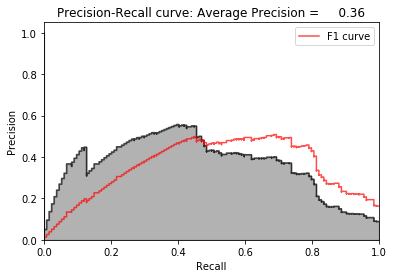

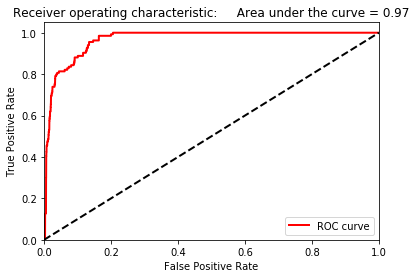

In [39]:
anomalyScoresPCA = anomalyScores(X_train, X_train_PCA_inverse)
preds = plotResults(y_train, anomalyScoresPCA, True)

In [40]:
preds.sort_values(by="anomalyScore",ascending=False,inplace=True)
cutoff = 200
predsTop = preds[:cutoff]

print("Anomalies Caught out of 200 Cases:", predsTop.trueLabel.sum()) # True Positive
TP = predsTop.trueLabel.sum()
FN = 200 - TP

Anomalies Caught out of 200 Cases: 81


In [41]:
preds.sort_values(by="anomalyScore",ascending=False,inplace=True)
cutoff = 10000
predsTop = preds[:cutoff]

print("Predicted as anomalies (but are not) caught out of 10000 Cases:", predsTop.trueLabel.sum()) # False Positive
FP = predsTop.trueLabel.sum()
TN = 10000 - FP

Predicted as anomalies (but are not) caught out of 10000 Cases: 134


In [42]:
print ("TP: ", TP)
print ("FN: ", FN)
print ("FP: ", FP)
print ("TN: ", TN)

TP:  81
FN:  119
FP:  134
TN:  9866


In [44]:
# Performance Matrix
accuracy = (TP+TN)/(TP+FN+FP+TN)
print ("Accuracy: ", np.round(accuracy, 2))
recall = TP/(TP+FN)
print ("recall: ", np.round(recall, 2))
specificity = TN/(TN+FP)
print ("Specificity: ", np.round(specificity, 2))
precision = TP/(TP + FP)
print ("precision: ", np.round(precision, 2))
F1 = 2/((1/precision) + (1/recall))
print ("F1: ", np.round(F1, 2))

Accuracy:  0.98
recall:  0.4
Specificity:  0.99
precision:  0.38
F1:  0.39
